[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Niegil-Francis/astromer_notebooks/blob/main/Tutorial_numpy_tf_records_data_prep.ipynb)


# Tutorial - Data preparation

This tutorial will go through the steps required to prepare any custom dataset to be trained on [Astromer](https://www.stellardnn.org/astromer/pages/about_astromer.html).

##### *Install the library*

In [ ]:
%%capture
!pip install test_model_hv

##### *Mount the drive containing the custom dataset*

In [ ]:
# Mounting Drive
from google.colab import drive
drive.mount('/content/drive/') 

Mounted at /content/drive/


##### *Import the necessary modules*

In [ ]:
# from core.astromer import ASTROMER 
from core.data import pretraining_data, create_dataset
import tensorflow as tf
import pandas as pd 
import numpy as np
import json
import glob
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import os
%load_ext autoreload
%autoreload 2

##### *Download and load the dataset (Two datasets shown as examples)*

In [ ]:
%%capture
!unzip "/content/drive/Shareddrives/AstroMer/raw_data/ogle.zip"
!unzip "/content/drive/Shareddrives/AstroMer/public/raw_data/alcock.zip"

#### **Storing as numpy arrarys**

##### *Read the data and store as a list of numpy arrays*

In [ ]:
%%time
# Storing a limited amount of data
n_lc_train = 100
n_lc_val = 30
n_lc_test = 30
train_data = []
for f in glob.glob("/content/ogle/LCs/OGLE*")[:n_lc_train]:
  train_data.append(pd.read_csv(f,sep=",").values)

val_data = []
for f in glob.glob("/content/ogle/LCs/OGLE*")[n_lc_train:n_lc_train+n_lc_val]:
  val_data.append(pd.read_csv(f,sep=",").values)

test_data = []
for f in glob.glob("/content/ogle/LCs/OGLE*")[n_lc_train+n_lc_val:n_lc_train+n_lc_val+n_lc_test]:
  test_data.append(pd.read_csv(f,sep=",").values)

CPU times: user 2.59 s, sys: 486 ms, total: 3.08 s
Wall time: 3.35 s


##### *Convert the list of numpy arrays into a TF dataset*

In [ ]:
train_dataset = pretraining_data(train_data, 16, max_obs=200, 
                              msk_frac=0.5, rnd_frac=0.2, same_frac=0.2,
                               shuffle=True)
val_dataset = pretraining_data(val_data, 16, max_obs=200, 
                              msk_frac=0.5, rnd_frac=0.2, same_frac=0.2,
                               shuffle=True)
test_dataset = pretraining_data(test_data, 16, max_obs=200, 
                              msk_frac=0.5, rnd_frac=0.2, same_frac=0.2,
                               shuffle=True)

[INFO] Shuffling
[INFO] Shuffling
[INFO] Shuffling


#### **Storing as TF datasets**

##### *Read and format the metadata*

In [ ]:
df = pd.read_table("/content/alcock/alcock_dataset.dat", sep=",")
display(df.head())
meta_df = df[['ID','Class','Path_B']]
meta_df['Band'] = 'B'
meta_df['Path'] = [i[8:] for i in meta_df['Path_B']]
meta_df = meta_df.drop(["Path_B"],axis=1)
meta_df = meta_df[meta_df.Class != "UNK"]
meta_df.head()

,ID,Class,rPer,bPer,Path_B,Path_R
0,1.3319.10,LPV,89.22144,88.74477,./LCs/B/1.3319.10.dat,./LCs/R/1.3319.10.dat
1,1.3441.15,Cep_0,10.41338,10.41338,./LCs/B/1.3441.15.dat,./LCs/R/1.3441.15.dat
2,1.3441.25,LPV,90.36836,89.65674,./LCs/B/1.3441.25.dat,./LCs/R/1.3441.25.dat
3,1.3441.45,Cep_0,3.36230,3.36224,./LCs/B/1.3441.45.dat,./LCs/R/1.3441.45.dat
4,1.3441.1031,RRab,0.50726,0.50726,./LCs/B/1.3441.1031.dat,./LCs/R/1.3441.1031.dat


,ID,Class,Band,Path
0,1.3319.10,LPV,B,1.3319.10.dat
1,1.3441.15,Cep_0,B,1.3441.15.dat
2,1.3441.25,LPV,B,1.3441.25.dat
3,1.3441.45,Cep_0,B,1.3441.45.dat
4,1.3441.1031,RRab,B,1.3441.1031.dat


##### *Read the data and store as tf records*

In [ ]:
%%time
create_dataset(meta_df,
                   source='/content/alcock/LCs',
                   target='/content/data/alcock/records',
                   n_jobs=None,
                   subsets_frac=(0.7, 0.1),
                   max_lcs_per_record=20000)

100%|██████████| 6/6 [01:19<00:00, 13.30s/it]

CPU times: user 1min 18s, sys: 1.63 s, total: 1min 19s
Wall time: 1min 19s


In [ ]:
meta_df.groupby('Class')

##### *Having a look at the light curves*

In [ ]:
data_preview = pretraining_data("/content/data/alcock/records/train",
                                batch_size = 256,
                                shuffle=False,
                                max_obs=200,
                                msk_frac=0.5,
                                rnd_frac=0.2,
                                same_frac=0.2,
                                mode = None)
label_dict = pd.read_csv("/content/data/alcock/records/objects.csv")['label'].to_dict()

[ 3 10]


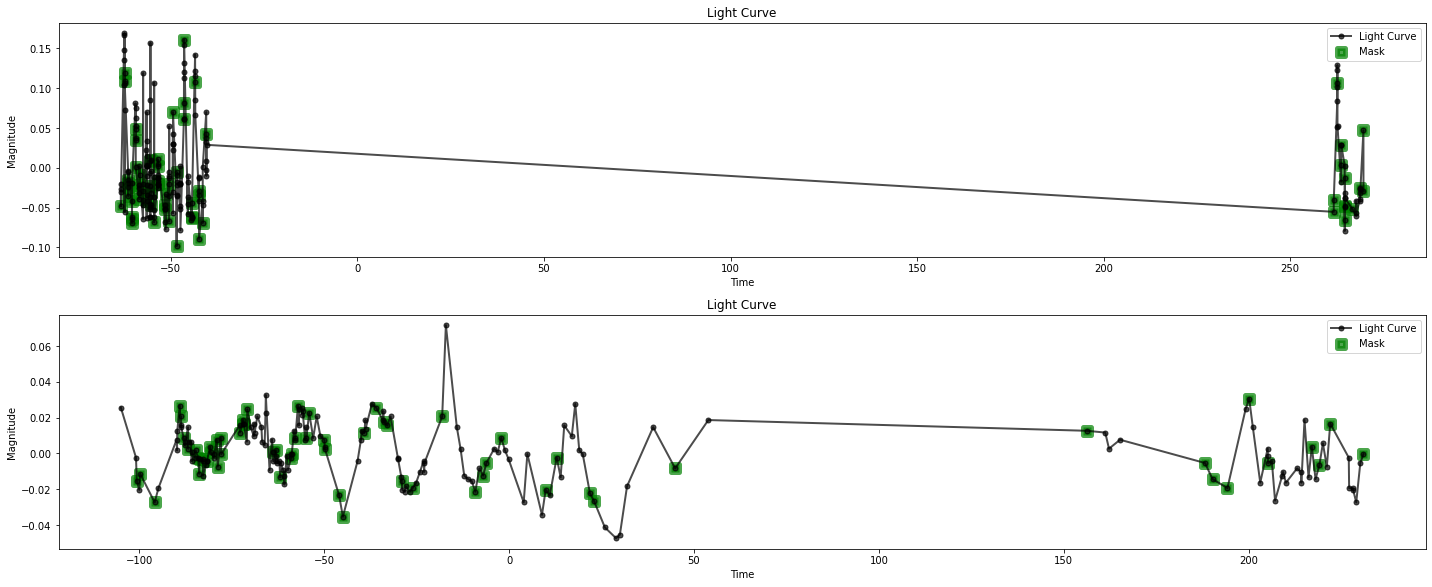

In [ ]:
for batch in train_dataset.take(1):
    # Taking 2 data at random and plotting the data
    val = np.random.randint(0,16, size=2)
    print(val)
    fig = plt.figure(figsize=(20,20))
    for count,i in enumerate(val):
      ax = fig.add_subplot(5,1,count+1)
      data = batch['input'][i]
      time = batch['times'][i]
      # label = batch['label'][i]
      mask_in = batch['mask_in'][i]
      mask_out = batch['mask_out'][i]
      
      data_masked_in = tf.boolean_mask(data, mask_in)
      data_masked_out = tf.boolean_mask(data, mask_out)
      time_masked_in = tf.boolean_mask(time, mask_in)
      time_masked_out = tf.boolean_mask(time, mask_out)


      ax.scatter(time_masked_in,data_masked_in,label='Mask',color='green',marker='s',alpha=0.7,linewidth=5,s=50)
      # label='Class '+label_dict[label.numpy()]+'
      ax.plot(time,data,label='Light Curve',color='black',marker='o',alpha=0.7,linewidth=2,markersize=5)
      ax.set_xlabel("Time")
      ax.set_ylabel("Magnitude")
      ax.title.set_text('Light Curve')
      ax.legend()
    fig.tight_layout();
